### Time Series prediction 


1. Visualize the series ( try to see underlying pattern like trend and seasonality)
2. Stationarizing time series (stationary - mean, variance, autocorrelation should be constant, transform the series t stationary )
3. Finding best parameters (from ACF and PACF plots)
4. Fitting model 
5. Predicitons 

### Predict Energy consumption

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 7]

In [6]:
df = pd.read_csv('Electric_Production.csv')
df.columns = ['Date', 'Consumption']
df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


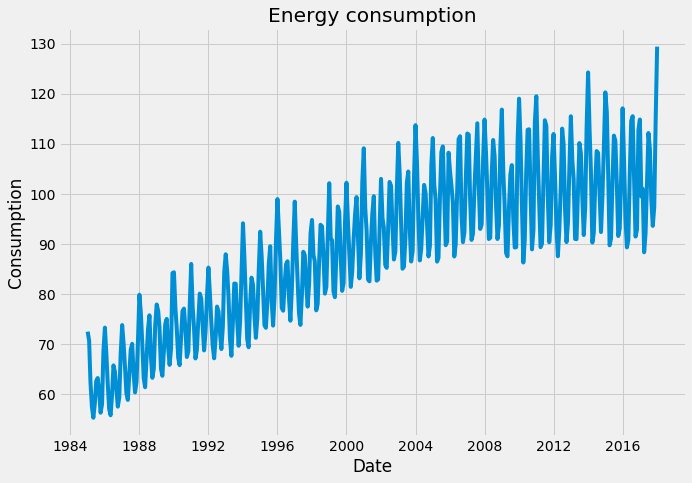

In [7]:
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Energy consumption')
plt.plot(df)

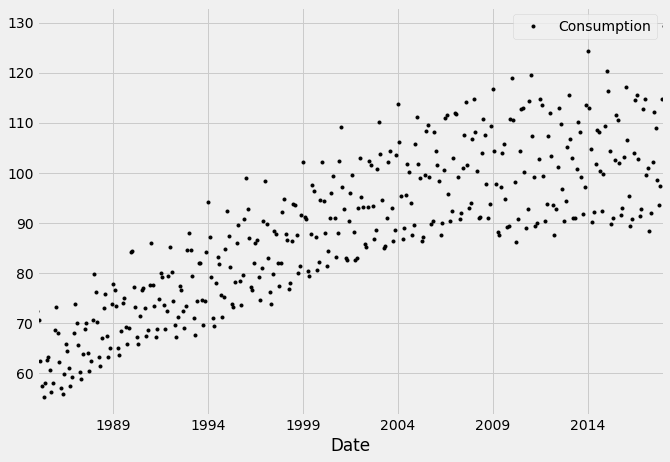

In [8]:
df.plot(style='k.')
plt.show()

Time series = Level + Trend + Seasonality + Noise

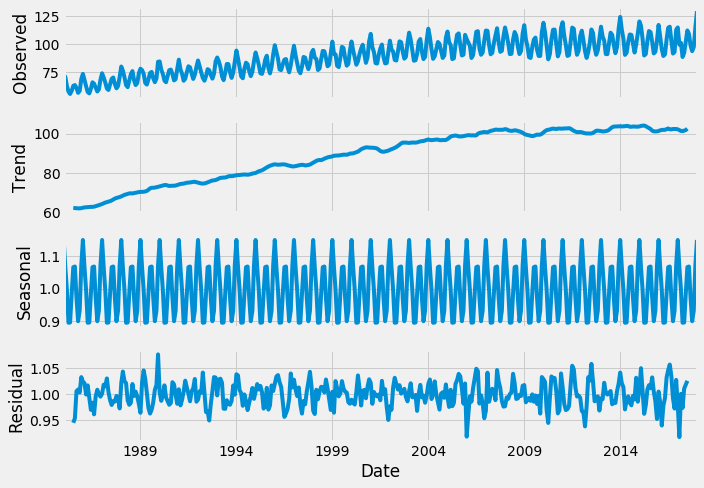

In [10]:
# Seperate trend and seasonality from time series

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multilicative')
result.plot()
plt.show()

### Check Stationarity of series
- ADF (Augmented Dickey-Fuller Test) is used to test stationarity
- ADF determines presence of unit root in series. 
- Null hypothesis - series has unit root
- Alternate hypothesis - Series has no unit root
- If we fail to reject null hypothesis, we can say that series is non-stationary
- If both mean and STD are flat lines (constant mean and variance) then series is stationary

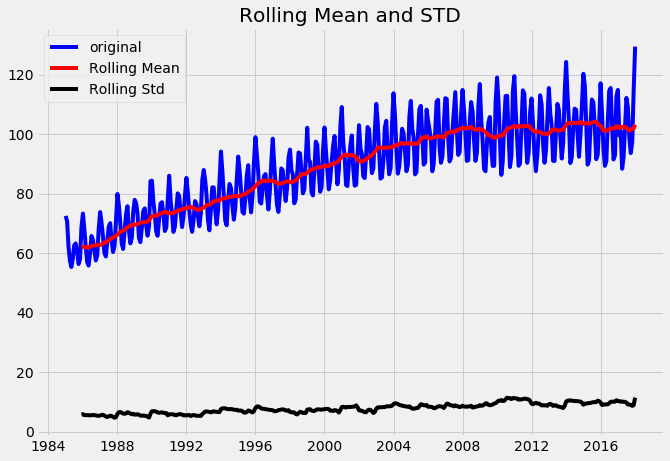

Results of dickey fuller test
Test Statistics              -2.256990
p-value                       0.186215
No. of lags used             15.000000
No. of observations used    381.000000
critical value (1%)          -3.447631
critical value (5%)          -2.869156
critical value (10%)         -2.570827
dtype: float64


In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # plot rolling statistics
    plt.plot(timeseries, color='blue', label='original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and STD')
    plt.show()
    
    # ADF test
    print('Results of dickey fuller test')
    adft = adfuller(timeseries['Consumption'], autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'No. of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' %key] = values
    print(output)
    
test_stationarity(df)    

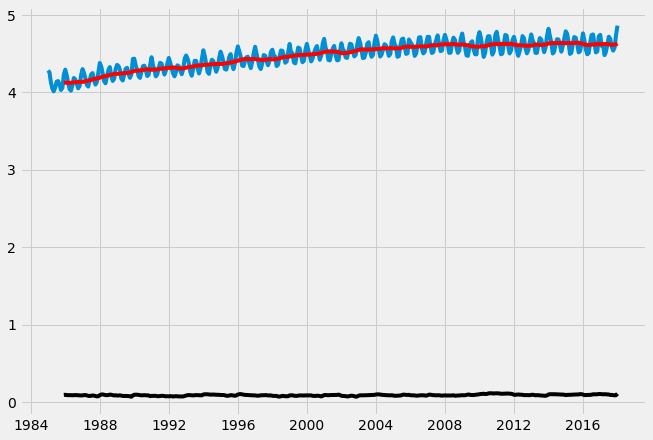

In [13]:
# P value is greater than 0.05. Thus, we cannot reject the null hypothesis
# Series is not stationary
# Make series stationary - log or differencing

df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color='red')
plt.plot(std_dev, color='black')
plt.show()

In [14]:
# Eliminate trend by taking difference of series with moving average

df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

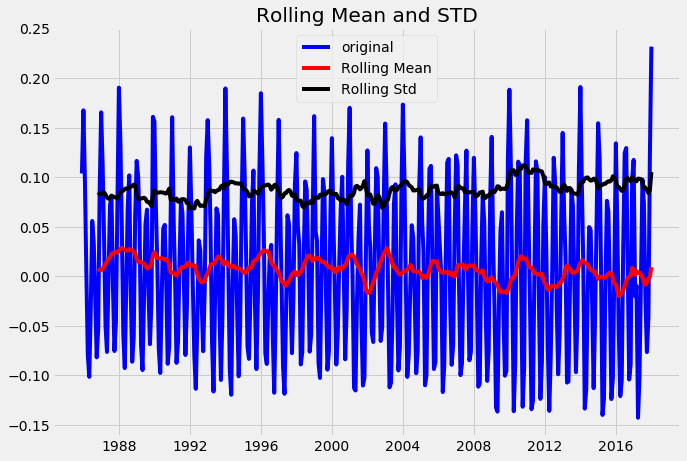

Results of dickey fuller test
Test Statistics              -5.211586
p-value                       0.000008
No. of lags used             15.000000
No. of observations used    370.000000
critical value (1%)          -3.448148
critical value (5%)          -2.869383
critical value (10%)         -2.570948
dtype: float64


In [15]:
# Perform dickey fuller test

test_stationarity(df_log_moving_avg_diff)

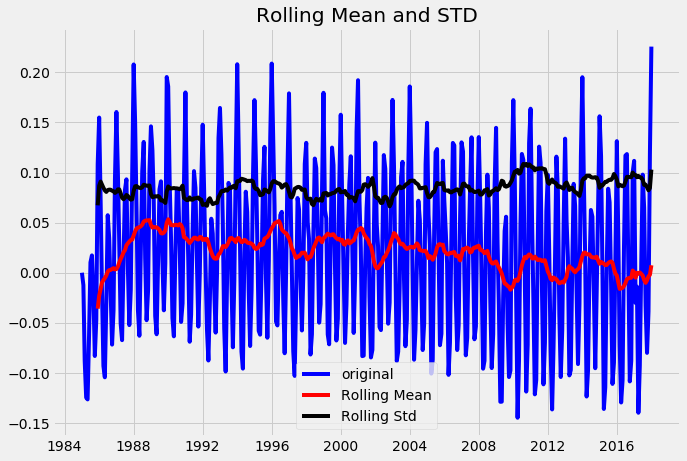

Results of dickey fuller test
Test Statistics              -3.251531
p-value                       0.017189
No. of lags used             15.000000
No. of observations used    381.000000
critical value (1%)          -3.447631
critical value (5%)          -2.869156
critical value (10%)         -2.570827
dtype: float64


In [16]:
# Series is stationary now
# Understand Trend 

weighted_average = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

logScale_weightedMean = df_log - weighted_average
test_stationarity(logScale_weightedMean)

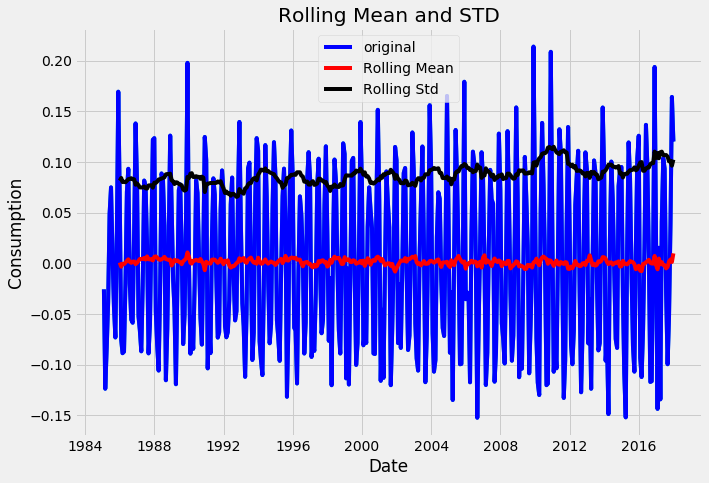

Results of dickey fuller test
Test Statistics            -6.748333e+00
p-value                     2.995161e-09
No. of lags used            1.400000e+01
No. of observations used    3.810000e+02
critical value (1%)        -3.447631e+00
critical value (5%)        -2.869156e+00
critical value (10%)       -2.570827e+00
dtype: float64


In [17]:
# For high seasonality data
# differencing is used to remove temporal dependence

df_log_diff = df_log - df_log.shift()
plt.title('Shifted Timeseries')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.plot(df_log_diff)
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

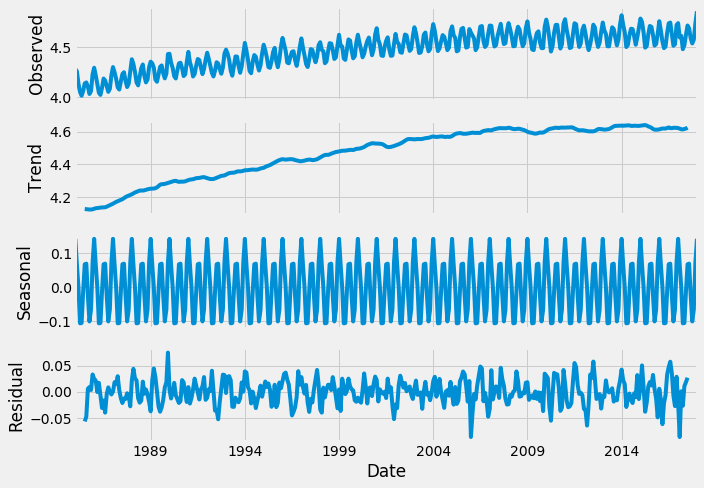

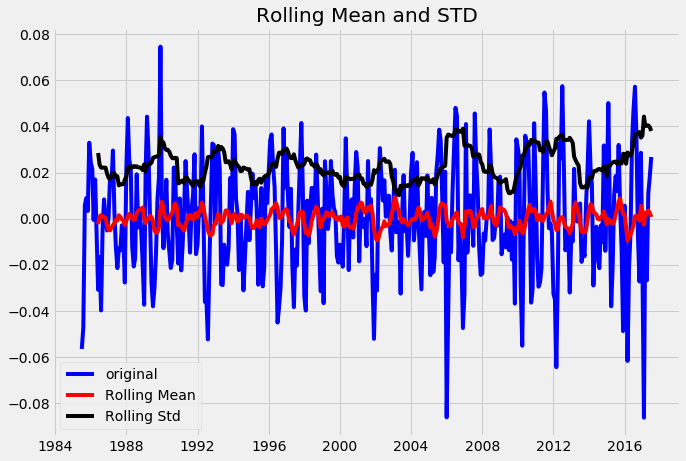

Results of dickey fuller test
Test Statistics            -1.000311e+01
p-value                     1.861632e-17
No. of lags used            1.400000e+01
No. of observations used    3.700000e+02
critical value (1%)        -3.448148e+00
critical value (5%)        -2.869383e+00
critical value (10%)       -2.570948e+00
dtype: float64


In [20]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq=12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity(residual)

### Finding the best parameters 
- We need ACF and PACF plots
- A nonseasonal arima model will have (p,d,q)
- P : Number of autoregressive terms
- D : Number of nonseasonal differences needed for stationarity
- Q : Number of lagged forecast errors in the prediction

Correlation for time series is with previous time steps called Lags. Because the correlation of time series is calculated with values of same series in previous time, this is called a serial correlation or an autocorrelation

ACF - A plot of autocorrelation of time series by lag is called autocorrlation function. 

PACF - Relation between an observation in a time series with observations at prior time steps after removing effect of any correlations due to terms at shorter lags

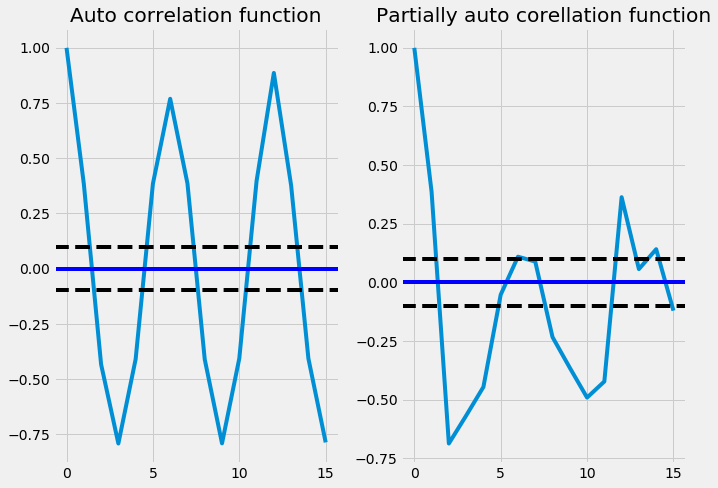

In [23]:
from statsmodels.tsa.stattools import acf, pacf
acf = acf(df_log_diff, nlags=15)
pacf = pacf(df_log_diff, nlags=15, method='ols')
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0, linestyle='-', color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.title('Auto correlation function')
plt.tight_layout()
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0, linestyle='-', color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

## Fitting the model 

p,d,q = (3,1,3) from the graphs above

RSS: 0.522671


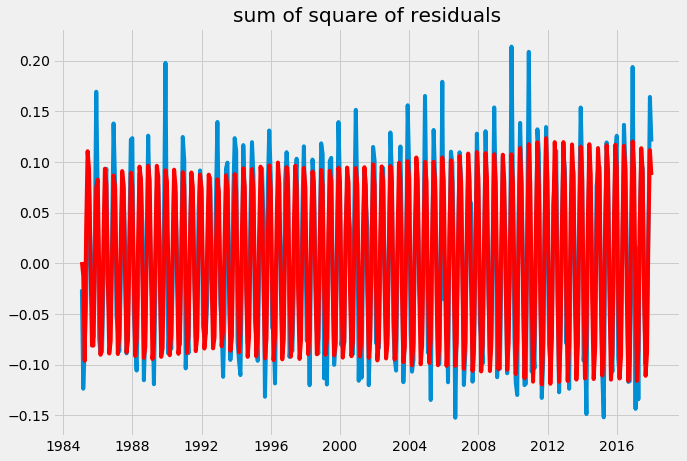

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('sum of square of residuals')
print("RSS: %f" %sum((result_AR.fittedvalues-df_log_diff['Consumption'])**2))

Check with different values of PDQ

Predictions

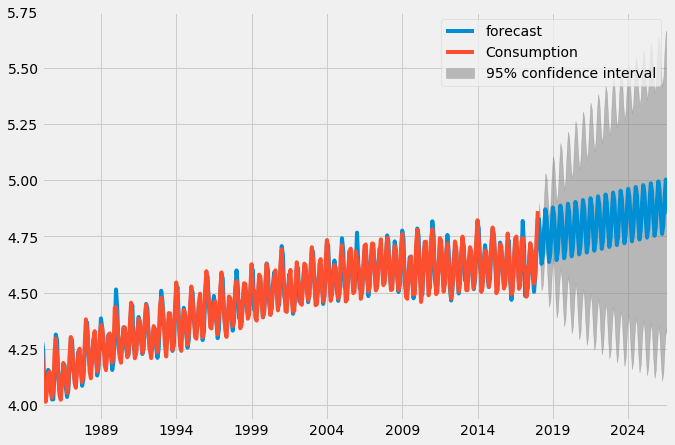

In [26]:
result_AR.plot_predict(1,500)
x = result_AR.forecast(steps=200)